In [1]:
import pandas as pd 
import numpy as np
import networkx as nx
import pickle
import os

In [128]:
dataroot = 'D:/study/thesis/project/HBDM-main/data/datasets/sc_vsmc_hv/'
 
 
sparse_i = np.loadtxt(dataroot+'sparse_i.txt')
sparse_j = np.loadtxt(dataroot+'sparse_j.txt')
sparse_w = np.loadtxt(dataroot+'sparse_w.txt')
 
sparse_i = sparse_i.astype(int)
sparse_j = sparse_j.astype(int)
sparse_w = sparse_w.astype(float)
 
# string_score_transform = np.vectorize(lambda x: -np.log(x/1000))
# transformed_w = string_score_transform(sparse_w)
# transformed_w = 11-(sparse_w*10).round()
edges_and_weights = zip(sparse_i, sparse_j,sparse_w)
 
G = nx.Graph()
 
# Use from_edgelist to directly create the graph from edges
G.add_weighted_edges_from(edges_and_weights)
# len(G.nodes)

In [129]:
components = list(nx.connected_components(G))
# Print information about each connected component
for i, component in enumerate(components):
    print(f"Component {i + 1}")

    # Extract the edges for each component
    subgraph = G.subgraph(component)
    component_edges = subgraph.edges()
    print('nodes',len(subgraph.nodes),'Edges:',len(subgraph.edges))

Component 1
nodes 5168 Edges: 1001047


## search cad genes

In [130]:
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'
model = 'Dataset-sc_vsmc_hv--RE-True--W-1--Epochs-5000--D-8--RH-25--LR-0.1--LP-False--CUDA-True/'

In [132]:
with open(dataroot+'ppi_index.pkl', 'rb') as file:
    ppi_index = pickle.load(file)
networkgenes = ppi_index.keys()
caddf = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\disease\Coronary_artery_disease.tsv',sep='\t')
cadlist = caddf['Gene'].tolist()
group_node = []
for gene in cadlist:
    if gene in networkgenes:
        group_node.append(ppi_index[gene])


In [133]:
len(group_node)

672

In [139]:
file_path = os.path.join(root, model + 'latent.pkl')
with open(file_path, 'rb') as f:
    node_rep = pickle.load(f)
node_rep = np.array(node_rep)
df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index
df = df_latent

# file_path = os.path.join(root, model + 're.pkl')
# with open(file_path, 'rb') as f:
#     re = pickle.load(f)

# node_rep = np.array(node_rep)
# re = np.array(re)
# data = np.concatenate((node_rep, re[:, np.newaxis]), axis=1)
# df_latent = pd.DataFrame()
# for d in range(data.shape[1]):
#     col_name = str(d+1)+'d'
#     df_latent[col_name] = data.T[d]
# df_latent['node'] = df_latent.index
# df = df_latent

In [14]:
from sklearn.neighbors import KDTree

In [138]:
ks = [5,10,15,20,50,100]
kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
for k in ks:
    start = []
    dist = []
    neighbor = []
    for i in group_node:
        given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
        # Perform a k-NN search to find the k+1 nearest neighbors
        distances, indices = kdtree.query(given_point, k=k)
        start += (k-1)*[i]
        dist += distances.reshape(-1).tolist()[1:]
        neighbor += indices.reshape(-1).tolist()[1:]


    neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
    # neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(group_node)]
    predict_df = neighbor_df['neighbor'].value_counts().to_frame()
    predict_df.reset_index(inplace=True)
    predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
    predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in group_node else 0, axis=1)
    selected_df = predict_df.head(10)
    print(k,len(selected_df[selected_df['true']==1])/10)

5 0.3
10 0.3
15 0.4
20 0.5
50 0.3
100 0.0


In [121]:
start = []
dist = []
neighbor = []
k = 20
for i in group_node:
    given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
    # Perform a k-NN search to find the k+1 nearest neighbors
    distances, indices = kdtree.query(given_point, k=k)
    start += (k-1)*[i]
    dist += distances.reshape(-1).tolist()[1:]
    neighbor += indices.reshape(-1).tolist()[1:]


neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
# neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(group_node)]
predict_df = neighbor_df['neighbor'].value_counts().to_frame()
predict_df.reset_index(inplace=True)
predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in group_node else 0, axis=1)
selected_df = predict_df.head(10)
print(k,len(selected_df[selected_df['true']==1])/10)

20 0.2


In [111]:
node2string = {v: k for k, v in ppi_index.items()}
selected_df['gene'] = selected_df['neighbor'].map(node2string.get)
selected_df

C:\Users\ZZY\AppData\Local\Temp\ipykernel_51044\2012012341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['gene'] = selected_df['neighbor'].map(node2string.get)


,neighbor,count,true,gene
0,2563,14,0,CCL8
1,5019,13,0,GBP4
2,3448,12,1,CXCL10
3,3492,12,0,CYP1B1
4,12418,12,1,TNFSF10
5,5021,12,0,GBP7
6,5016,11,0,GBP1
7,12067,11,1,THBS1
8,2061,11,0,BTG2
9,6072,10,1,IRF1


### cad cluster

In [52]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import gseapy as gp

In [122]:
# Specify the variable names
# variable_names = ['k_exp_dist','final_idx', 'general_cl_id', 'general_mask']
variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
# Initialize a dictionary to store the loaded variables
loaded_variables = {}

# Loop through the variable names and load the data from pickle files
for var_name in variable_names:
    file_path = os.path.join(root,model, var_name + '.pkl')
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    loaded_variables[var_name] = loaded_data

# Access the loaded variables as needed
k_exp_dist = loaded_variables['k_exp_dist']
# final_idx = loaded_variables['final_idx']
general_cl_id = loaded_variables['general_cl_id']
general_mask = loaded_variables['general_mask']

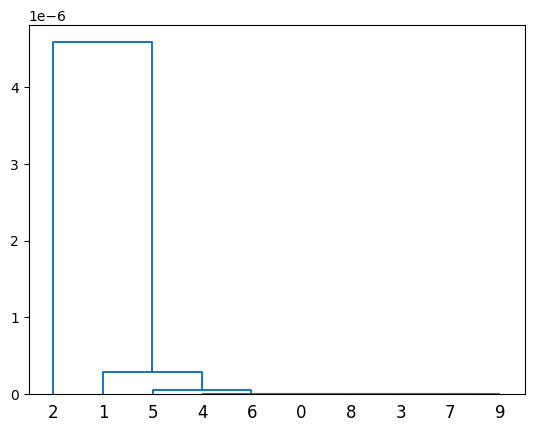

In [123]:
k_exp_dist = np.array(k_exp_dist)
# Create your matrix of within-cluster Euclidean distances
first_level_cls = len(set(list(general_cl_id[0])))
distance_matrix = k_exp_dist[:first_level_cls,:first_level_cls]
# distance_matrix = k_exp_dist[30:70,30:70]
# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='average')
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)

# plt.title('Post-Processing Agglomerative Clustering Dendrogram')
# plt.xlabel('Clusters')
# plt.ylabel('Euclidean Distance')
# plt.savefig(pltroot+'Dendrogram-'+name+'.png')
# plt.show()

order = dendrogram['leaves']

In [114]:
level_list = []
# check the cluster ids in different levels
for i in general_cl_id:
    a = list(set(i))
    level_list.append(a)
    print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
[150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

In [115]:
index_dict = dict()
for i, l in enumerate(general_cl_id):
    for j, cluster in enumerate(l):
        if cluster in index_dict:
            index_dict[cluster].append(general_mask[i][j])
        else:
            index_dict[cluster] = [general_mask[i][j]]

In [116]:
level_dict = dict()
for i in range(len(level_list)):
    if i == len(level_list)-1:
        l = level_list[i]
        for c1 in l:
            level_dict[c1] = []
    else:
        l = level_list[i]
        subl = level_list[i+1]
        # print(l,subl)
        for c1 in l:
            # print(c1)
            for c2 in subl:
                # print(c2)
                if set(index_dict[c1]) & set(index_dict[c2]):
                    # print(c2 ,'in',c1)
                    if c1 in level_dict:
                        level_dict[c1].append(c2)
                    else:
                        level_dict[c1] = [c2]
            if c1 not in level_dict:
                level_dict[c1] = []

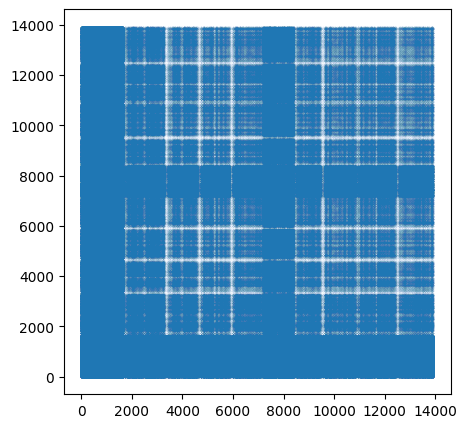

In [117]:
index = []
for i in order:
    index.extend(index_dict[i])
len(index)
ad = nx.to_numpy_array(G, dtype=bool, nodelist=index)
coords = np.argwhere(ad==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.00005)
plt.show()

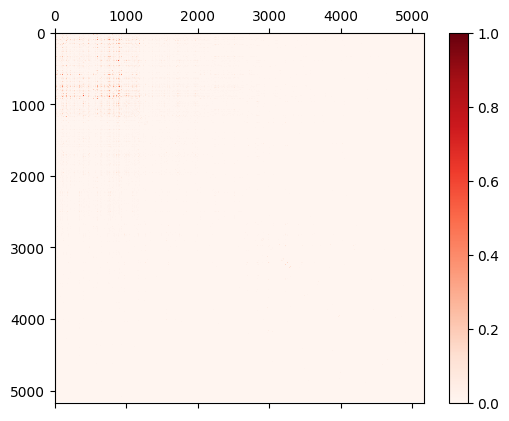

In [100]:
# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

# Convert the adjacency matrix to a binary matrix
binary_matrix = adj_matrix > 0

# Plot the binary matrix
fig, ax = plt.subplots()
# cax = ax.matshow(binary_matrix, cmap='Reds')
cax = ax.matshow(adj_matrix, cmap='Reds')

# Display the colorbar
fig.colorbar(cax)

plt.show()

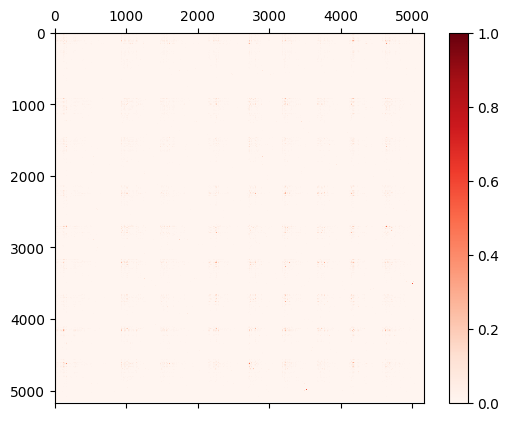

In [102]:
# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

adj_matrix_reordered = adj_matrix[np.ix_(index, index)]
# binary_matrix = adj_matrix_reordered > 0
# Plot the binary matrix
fig, ax = plt.subplots()
# cax = ax.matshow(binary_matrix, cmap='Reds')
cax = ax.matshow(adj_matrix_reordered, cmap='Reds')
# Display the colorbar
fig.colorbar(cax)

plt.show()

### other levels

In [ ]:
# G1 = nx.Graph()
# # Add nodes and edges based on the dictionary
# for node, neighbors in level_dict.items():
#     G1.add_node(node)
#     G1.add_edges_from((node, neighbor) for neighbor in neighbors)
# def find_deep_end_nodes(graph, start_node, depth, current_depth=0, visited=None):
#     if visited is None:
#         visited = set()
#     visited.add(start_node)
    
#     neighbors = list(graph.neighbors(start_node))
    
#     # Check if the current node is at the desired depth
#     if current_depth == depth:
#         return [start_node]
    
#     deep_end_nodes = []
#     for neighbor in neighbors:
#         if neighbor not in visited:
#             deep_end_nodes.extend(find_deep_end_nodes(graph, neighbor, depth, current_depth + 1, visited))
    
#     return deep_end_nodes


# depth = 2
# end_orders = []
# for i in order:
#     start_node = i
#     end_nodes = find_deep_end_nodes(G1, start_node, depth)
#     end_orders.extend(end_nodes)

# index = []
# for i in end_orders:
#     index.extend(index_dict[i])
# len(index)